# Deep Learning Project: Orca Vocalization Clustering

## Karlee Zammit - V00823093

Electromagnetic radiation does not propagate as efficiently as sound in the water, and so marine mammals have evolved to use sound for all aspects of their lives. Passive acoustic monitoring (PAM) is the main method used for collecting acoustic data of marine mammals, and for detecting and localizing animals using this data. PAM data is time consuming and costly to analyze manually, and so there is motivation to develop automated detection techniques. 

Deep learning automated acoustic detection methods have been applied to a wide variety of marine mammals, such as orca, humpback whale, fin whales, and blue whales. Typically the workflow is as follows: 

1. Have an expert bioacoustician annotate as many calls within the PAM data as possible 
2. Convert the audio files into spectrograms of a specified length 
3. Preprocess the spectrograms (normalize, convert to dB scale, etc) 
4. Pass the spectrograms as image data to train a deep learning network, such as ResNet-18 
5. Use the trained model to predict classifications (multiclass or binary) on unseen data 

Binary classifications are typically "call" or "no call" within a segment, and multi-class classifications can attempt to further classify detected vocalizations. These detections and classifications can be used to inform conservation efforts, providing a baseline for presence or absence of a species within a region of interest. 

The major limitation of supervised automated detection techniques is the large number of annotations needed to produce a reliable and robust network. Unsupervised clustering can potentially address this by removing the need for an expert bioacoustician to start from fully unannotated wave files. Clustering results can be explored to determine if vocalizations have been clustered seperately from spectrograms containing no vocalizations, which would therefore aid in the creation of annotated spectrograms for use in training supervised techniques. 

In this notebook I apply unsupervised clustering techniques (UMAP and Kmean) to data containing orca vocalizations. The notebook is laid out as follows: 

1. Load in the data, and create spectrograms in both dB scale and amplitude scale 
2. Define two different models: a linear autoencoder and a convolutional autoencoder 
3. Train both of these models on datasets containing the dB scale and amplitude spectrograms separately 
4. Use the trained models to compute latent space representations of the input data 
5. Use UMAP and KMean to cluster the data, colouring by "call" or "no call" 
6. Explore the clusters
7. Discussion of the results 
8. An attempt at creating a binary classifier using a pretrained ResNet-50 model is included, but I did not finish this. 

# Import Packages

In [1]:
# Import the necessary packages
from __future__ import print_function, division
import os
import os.path, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
from torchvision.io import read_image
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
import torchvision.models as models
import librosa
import wave
from IPython.display import Audio
from skimage import io, transform
from PIL import Image, ImageOps
!pip install umap-learn
!pip install umap-learn[plot]
import umap
import umap.plot
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=0de81f5f70c7769d1016bdc86cb5872695251d6e379658b36f89fafcd1ac35aa
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=ff027bd6b6d8ccf29d6feaf5353fb7a38db6712848569675b64085c5408e1893
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

# Functions

In [2]:
# Plot and save the waveform from the wave file - not used other than for interest 
def plot_waveform(idx, waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.xlabel('Time')
    plt.show(block=False)
    #plt.savefig(r'C:\Users\kzammit\Repos\school\phys555\project-DL\orcas_classification\wavpngs\wav-' + str(idx) + '.png')
    plt.close()

In [3]:
# Plot and save the spectrogram from the wave file
def create_spectrogram(idx, specgram):

    # set the transform to PIL Image
    transform=transforms.ToPILImage()

    # transform the input spectrogram to a PIL image
    specgram= transform(specgram)

    #so low frequencies are at the bottom  
    specgram = ImageOps.flip(specgram)

    # for dB-scale spectrograms 
    #specgram.save(r"/content/drive/MyDrive/Masters/PHYS555/DL/specs/spec-" + str(idx) + ".png")

    # for mag-scale spectrograms 
    #specgram.save(r"/content/drive/MyDrive/Masters/PHYS555/DL/magspecs/spec-" + str(idx) + ".png")

    # display an example 
    display(specgram)
    

In [4]:
# Crop the spectrogram figures and save as pngs (not used anymore)
def crop(path, dirs):
    for item in dirs:
        fullpath = os.path.join(path,item)
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            f, e = os.path.splitext(fullpath)
            # last one does the height
            # left top right bottom
            imCrop = im.crop((80, 58, 475, 425)) #corrected
            #imCrop.save(f + '-crop.png', "PNG", quality=300)
            display(imCrop)

In [5]:
# preprocess the spectrograms
def preprocess():
    
    transform =  transforms.Compose([
        # convert to python image library image 
        transforms.ToPILImage(),
        # resize
        transforms.Resize(256),
        # center crop
        transforms.CenterCrop(224),
        # convert to tensor 
        transforms.ToTensor()])
  
    return transform

# Data 

The dataset containing the orca vocalizations was obtained from: https://github.com/earthspecies/library/tree/main/orcas 

It contains 593 4-second audio segments, with an associated annotations csv file with "call" or "no_call" distinction. I edited this annotations file to have the corresponding spectrogram.png file name associated with the call type for use in the deep learning network. 

# Spectrogram Generation and Preprocessing

To create the spectrograms, I used a google-drive mounted repository containing the audio wave files. I pass the folder containing the audio segments, and convert them into spectrograms with defined parameters. Below I plot an example of a waveform and spectrogram created using the script below.

In [ ]:
#!unzip -uq "/content/drive/My Drive/Masters/PHYS555/DL/audio.zip" -d "/content/drive/My Drive/Masters/PHYS555/DL"

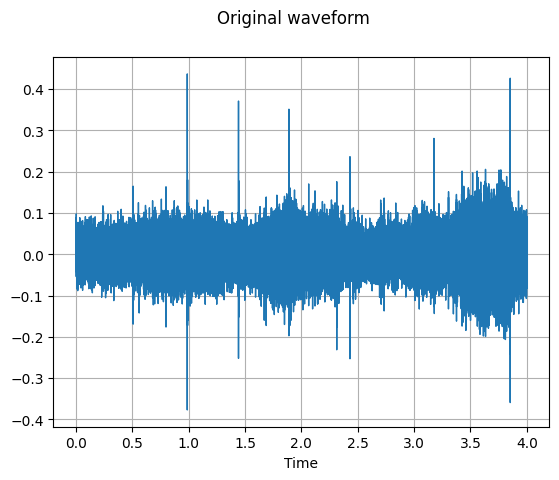

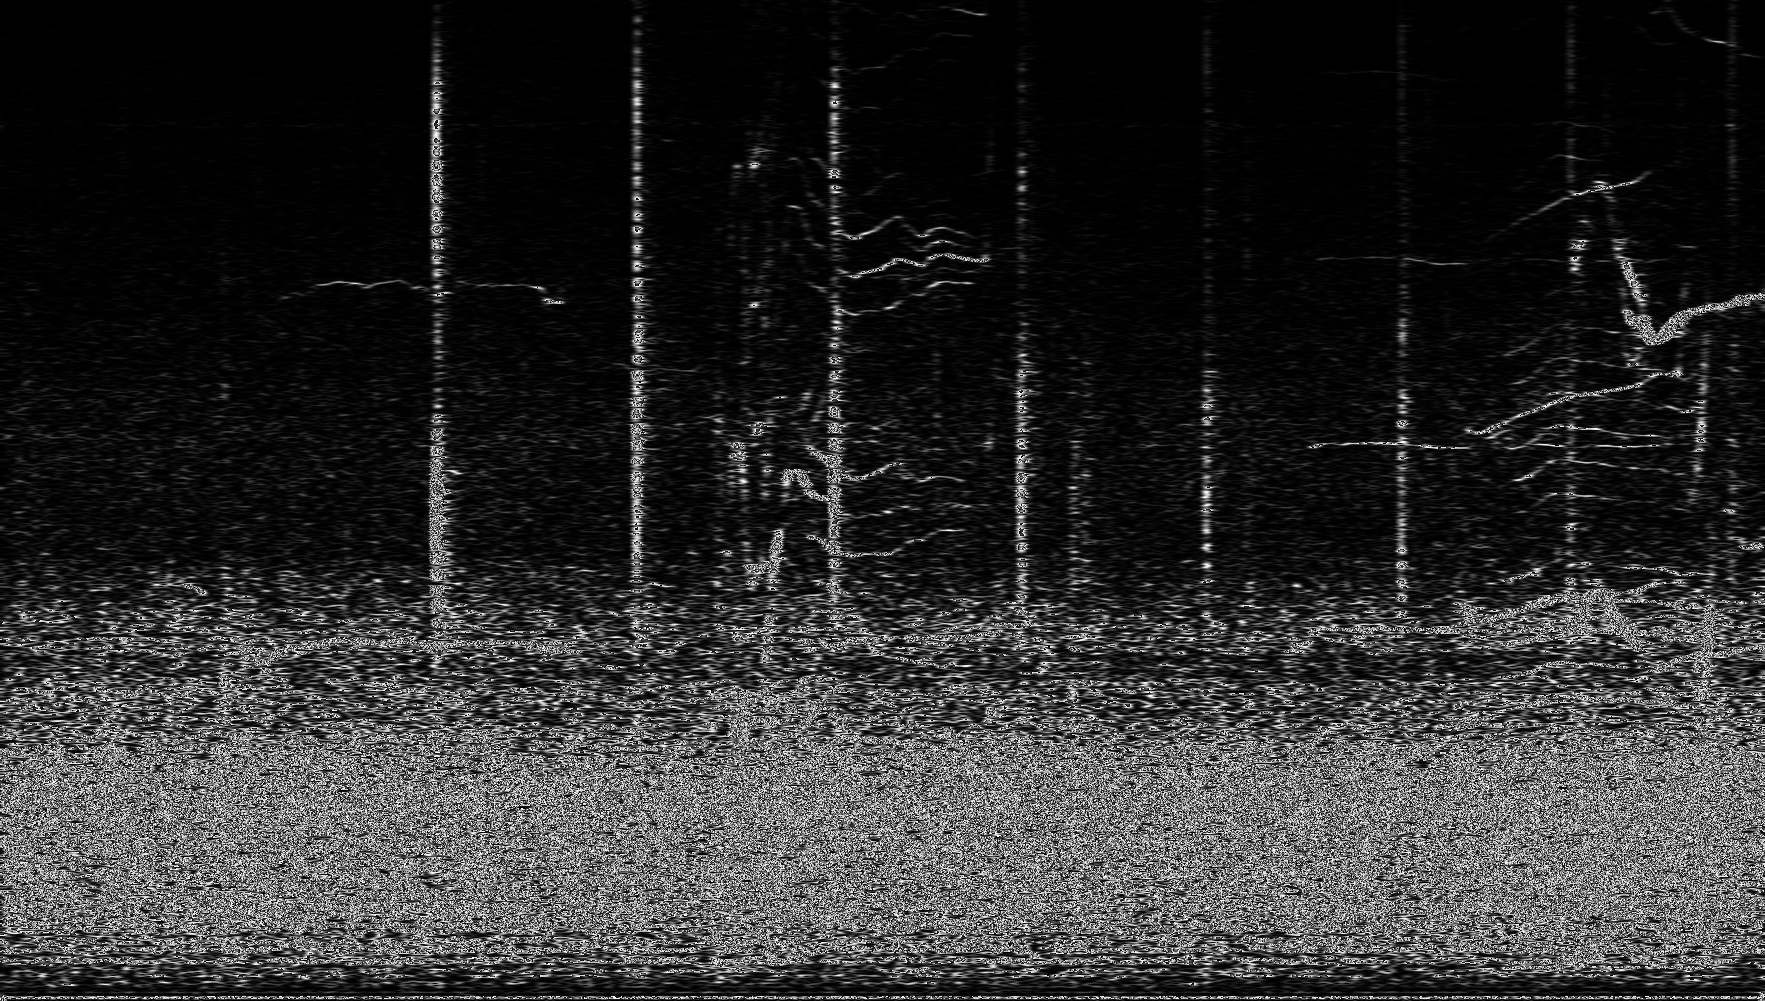

In [6]:
# https://pytorch.org/audio/main/generated/torchaudio.transforms.AmplitudeToDB.html
# For each available wave file
for ii in range(12, 13):
    
    # Set the path to the audio folder 
    path = r'/content/drive/MyDrive/Masters/PHYS555/DL/audio'
    
    # Get the file name and path
    file = '/' + str(ii) + '.wav'

    fullfile = path + file

    # Set the sample to this file
    SAMPLE_WAV = fullfile

    # Load the wave with torchaudio a
    ORCA_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_WAV, normalize=True)

    # Convert from amplitude to db scale spectrograms 
    transform = T.AmplitudeToDB(stype="amplitude", top_db=100)
    orca_waveform_db = transform(ORCA_WAVEFORM)

    # Plot the original waveform 
    plot_waveform(idx=str(ii), waveform=ORCA_WAVEFORM, sr=SAMPLE_RATE, title="Original waveform")
    #plot_waveform(idx=str(ii), waveform=orca_waveform_db, sr=SAMPLE_RATE, title="Original waveform")

    Audio(ORCA_WAVEFORM.numpy(), rate=SAMPLE_RATE)
    #Audio(orca_waveform_db.numpy(), rate=SAMPLE_RATE)

    # Set the spectrogram parameters 
    n_fft = 2000
    win_length = 2000
    hop_length = 100

    # Define spectrogram settings using torch audio transforms  
    spectrogram = T.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length, center=True, pad_mode="reflect", power=2.0)
    
    # Calculate the spectrogram 
    spec = spectrogram(ORCA_WAVEFORM)
    #spec = spectrogram(orca_waveform_db)
    
    # Plot and save the spectrogram
    create_spectrogram(idx=str(ii), specgram=spec[0])

# Data Loading

In this section, I create a dataset class, and create two datasets:

1. dB-scale spectrograms and associated data loaders 
2. Amplitude scale spectrograms and associated data loaders 

I decided to compare the results for these two different spectrogram scaling because other published works (such as Bergler et. al. (2019)) have stated that decibel scale spectrograms have resulted in higher accuracy and precision for their binary classifiers. 

In [7]:
# create the orca image dataset class 
class OrcaImageDataset(Dataset):
    
    def __init__(self, annotations_file, img_dir, transform, target_transform=None):
        # define the labels (ie. call, or no call)
        self.img_labels = pd.read_csv(annotations_file)
        # set the image directory containing the spectrograms 
        self.img_dir = img_dir
        # set the transform 
        self.transform = transform
        # no transform is needed for the target 
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # get the image and label when requested 
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = image.squeeze()
        label = self.img_labels.iloc[idx, 1]
        # transform the image according to the defined transform 
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        # return the image and the label 
        return image, label

## dB Scale Dataset

In [8]:
# set the path to the annotations file 
annotations_file = r"/content/drive/MyDrive/Masters/PHYS555/DL/annotations-edited.csv"
# set the path to the img directory 
img_dir = r"/content/drive/My Drive/Masters/PHYS555/DL/specs/"
# define the transform needed for the spectrograms 
transforms_eff = preprocess()
# create an orcaImageDataset object 
orca_dataset_db = OrcaImageDataset(annotations_file, img_dir, transform=transforms_eff)
# define the labels for the dataset 
labels_db = orca_dataset_db.img_labels

In [10]:
# split into a testing and training dataset 
xtrain_data_db, test_data_db, ytrain_labels_db, test_labels_db = train_test_split(orca_dataset_db, labels_db, test_size=0.2, random_state=21)

#  split a validation set from the training set
train_data_db, val_data_db, train_labels_db, val_labels_db = train_test_split(
    xtrain_data_db, ytrain_labels_db, test_size=0.2, random_state=22)

In [11]:
print('The number of samples for training is ' + str(len(train_data_db)))
print('The number of samples for validation is ' + str(len(val_data_db)))
print('The number of samples for testing is ' + str(len(test_data_db)))

The number of samples for training is 380
The number of samples for validation is 95
The number of samples for testing is 119


In [12]:
# define data loaders 
batch_size = 1
train_loader_db = DataLoader(train_data_db, batch_size=batch_size, shuffle=True)
val_loader_db = DataLoader(val_data_db, batch_size=batch_size, shuffle=True)
test_loader_db = DataLoader(test_data_db, batch_size=batch_size, shuffle=True)

In [129]:
# Get data loader for the entire dataset as well for generating latent spaces
entireset_db = DataLoader(orca_dataset_db, batch_size=batch_size, shuffle=True)

## Amplitude Scale Dataset

In [13]:
# as before, create an orcaImageDataset object for the amplitude scale spectrograms 
img_dir_a = r"/content/drive/My Drive/Masters/PHYS555/DL/magspecs/"
transforms_eff = preprocess()
orca_dataset_a = OrcaImageDataset(annotations_file, img_dir_a, transform=transforms_eff)
labels_a = orca_dataset_a.img_labels

In [15]:
# split into train and test data 
xtrain_data_a, test_data_a, ytrain_labels_a, test_labels_a = train_test_split(orca_dataset_a, labels_a, test_size=0.2, random_state=21)

#  split a validation set from the training set
train_data_a, val_data_a, train_labels_a, val_labels_a = train_test_split(
    xtrain_data_a, ytrain_labels_a, test_size=0.2, random_state=22)

In [16]:
print('The number of samples for training is ' + str(len(train_data_a)))
print('The number of samples for validation is ' + str(len(val_data_a)))
print('The number of samples for testing is ' + str(len(test_data_a)))

The number of samples for training is 380
The number of samples for validation is 95
The number of samples for testing is 119


In [17]:
# create data loaders
batch_size = 1
train_loader_a = DataLoader(train_data_a, batch_size=batch_size, shuffle=True)
val_loader_a = DataLoader(val_data_a, batch_size=batch_size, shuffle=True)
test_loader_a = DataLoader(test_data_a, batch_size=batch_size, shuffle=True)

In [20]:
# Get data loader for the entire dataset as well 
entireset_a = DataLoader(orca_dataset_a, batch_size=batch_size, shuffle=True)

# Data Visualization

In this section I print out some aspects of the data for visualization. I present 10 examples of the dB scale spectrograms, and 10 examples of the amplitude spectrograms.

## dB scale 

In [21]:
# print the file name and associated labels 
print(orca_dataset_db.img_labels)

              fn2    label
0      spec-0.png     call
1      spec-1.png     call
2      spec-2.png     call
3      spec-3.png     call
4      spec-4.png     call
..            ...      ...
589  spec-589.png  no_call
590  spec-590.png  no_call
591  spec-591.png  no_call
592  spec-592.png  no_call
593  spec-593.png  no_call

[594 rows x 2 columns]


In [25]:
print('The shape of tensor for 60th image in train dataset: ', orca_dataset_db[60][0].shape)

The shape of tensor for 60th image in train dataset:  torch.Size([1, 224, 224])


In [26]:
# print an example 
print(orca_dataset_db[60][0])

tensor([[[0.4824, 0.4235, 0.4392,  ..., 0.4706, 0.5804, 0.5059],
         [0.5804, 0.5020, 0.4706,  ..., 0.5373, 0.5020, 0.4000],
         [0.5725, 0.5333, 0.3882,  ..., 0.4980, 0.5020, 0.4784],
         ...,
         [0.4392, 0.4745, 0.5294,  ..., 0.3961, 0.4431, 0.5647],
         [0.5137, 0.3804, 0.3725,  ..., 0.4471, 0.4667, 0.4706],
         [0.4863, 0.4980, 0.4392,  ..., 0.3608, 0.2314, 0.3216]]])


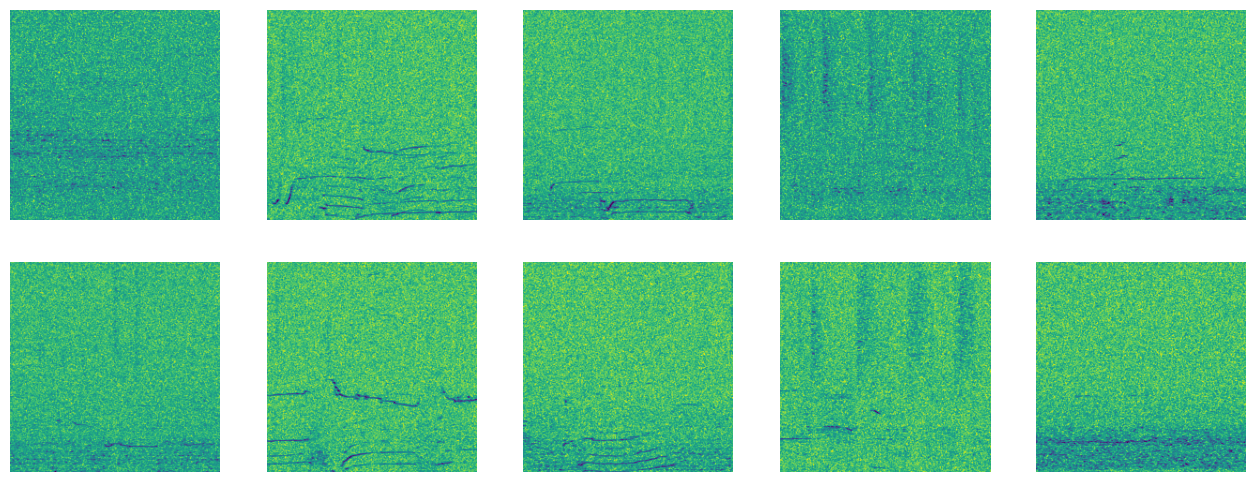

In [27]:
# plot 10 example dB scaled spectrograms 
transform = transforms.ToPILImage()
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader_db.dataset.__getitem__(i)
    #print(image.shape)
    image = transform(image)
    plt.imshow(image)
    plt.axis('off');
    #print(image.size)

As seen above, the dB scale spectrograms have removed some background artifacts, but have also removed some call structures within the spectrogram. In the cases where the call structure has remained, it is easier to pick out than in the amplitude spectrograms.

## Amplitude Scale

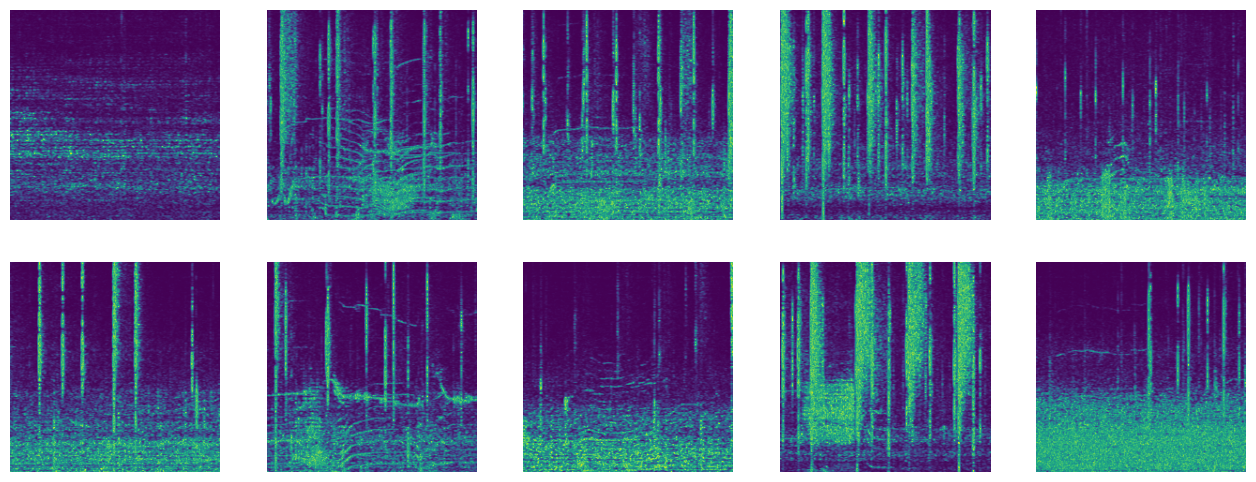

In [28]:
transform = transforms.ToPILImage()
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader_a.dataset.__getitem__(i)
    #print(image.shape)
    image = transform(image)
    plt.imshow(image)
    plt.axis('off');
    #print(image.size)

As seen above, the amplitude spectrograms have much more structure than the dB spectrograms. Although this is true, the vertical lines within these spectrograms are not orca calls, and are hypothesized to potentially confuse the detector for learning the features of orca vocalizations. 

# Models

In this section I define the testing and training loop, and two autoencoder models: 

1. A linear autoencoder 
2. A convolutional autoencoder 

Our class notebooks were referenced to create these networks, as well as the pytorch documentation.

In [59]:
# Train/test loop 
def train_test_model(model, train_loader, val_loader, n_epochs, optimizer):
    criterion = nn.MSELoss()
    optimizer = optimizer
    model = model.train()
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        train_batch_losses = []
        val_batch_losses = []
        for data in train_loader:
            img, _ = data
            #img = img.squeeze()
            #print(img.shape)
            img = img.to(device)
            #img = img.reshape(-1, 28*28)
            
            #print(img.shape)
            output = model(img)
            loss = criterion(output, img.data)
            #************************ backward *************************
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_batch_losses.append(loss.item()) 
            
        model = model.eval()
        for data in val_loader:
            output = model(img)
            loss = criterion(output, img.data)
            val_batch_losses.append(loss.item())
            
        train_loss = np.mean(train_batch_losses)
        val_loss = np.mean(val_batch_losses)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
            
        # ***************************** log ***************************
        if epoch % 10 == 0:
            print(f"epoch [{epoch + 1}/{n_epochs}], Train loss:{train_loss: .4f} Valid:{val_loss: .4f}")

    # Plot training loss for both training and validation sets        
    ax = plt.figure().gca()
    ax.plot(train_losses)
    ax.plot(val_losses)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'])
    plt.title('Loss monitoring')
    plt.show()
    
    return model.eval()

In [30]:
# Linear Autoencoder 
class LinearAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()        

        ## define the encoder ##
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(224, 224),
            torch.nn.ReLU(),
            torch.nn.Linear(224, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            # latent space of size 64x10 (random choice)
            torch.nn.Linear(64, 10)
        )
          
        ## define the decoder ##
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 224),
            torch.nn.ReLU(),
            torch.nn.Linear(224, 224),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        # return the reconstructed input (decoded image) as the output 
        return decoded

In [31]:
# Convolutional autoencoder 
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        ## encoder layers ##
        self.encoder = nn.Sequential( 
            nn.Conv2d(1,16,3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(16,4,3, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(2,2)
        )
        
        ## decoder layers ##
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4,16,2, stride=2), 
            nn.ReLU(), 
            nn.ConvTranspose2d(16,1,2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Training

## dB Scale

LinearAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=224, out_features=224, bias=True)
    (1): ReLU()
    (2): Linear(in_features=224, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=224, bias=True)
    (5): ReLU()
    (6): Linear(in_features=224, out_features=224, bias=True)
    (7): Sigmoid()
  )
)
epoch [1/100], Train loss: 0.0047 Valid: 0.0069
epoch [11/100], Train loss: 0.0039 Valid: 0.0029
epoch [21/100], Train loss: 0.0032 Valid: 0.0028
epoch [31/100], Train loss: 0.0032 Valid: 0.0034
epoch [41/100], Train loss: 0.0032 Valid: 0.0029
epoch [51/100], Train loss: 0.0032 Valid: 0.0036
epoch [61/100], Train l

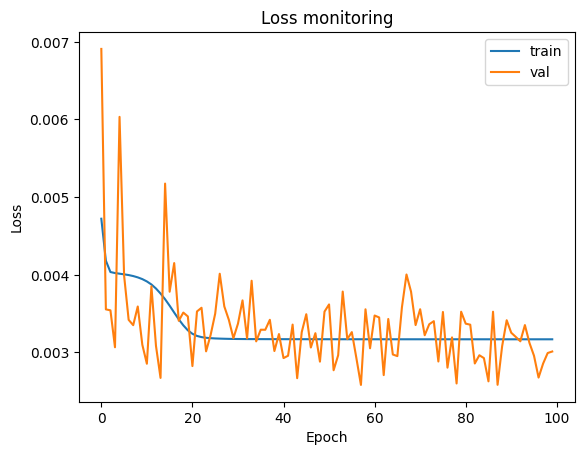

In [32]:
# Instantiating the model and hyperparameters
model = LinearAutoencoder().to(device)
print(model)
n_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
linear_model_db = train_test_model(model, train_loader_db, val_loader_db, n_epochs, optimizer)

As seen above, the linear autoencoder training and validation sets perform poorly and never reaches a loss of zero. This model most likely is not a suitable model for clustering, but this will be discussed later in the notebook.

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)
epoch [1/100], Train loss: 0.0174 Valid: 0.0163
epoch [11/100], Train loss: 0.0055 Valid: 0.0041
epoch [21/100], Train loss: 0.0042 Valid: 0.0043
epoch [31/100], Train loss: 0.0041 Valid: 0.0030
epoch [41/100], Train loss: 0.0039 Valid: 0.0031
epoch [51/100], Train loss: 0.0038 Valid: 0.0040
epoch [61/100], Train loss: 0.0036 Valid: 0.0033
epoch [71/100], Train loss: 0.0033 Valid: 0.0033
epoch [81/100],

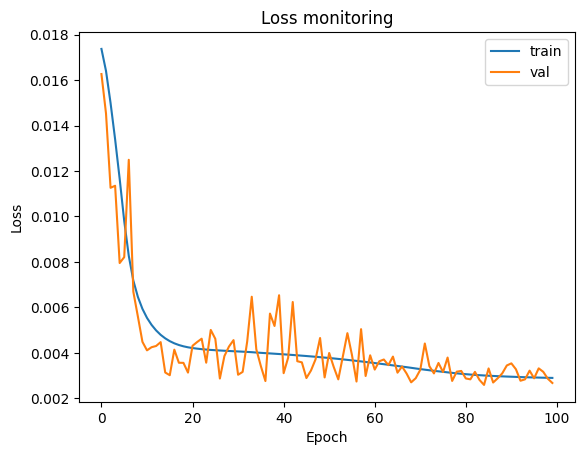

In [33]:
# initialize the NN
model = ConvAutoencoder().to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
n_epochs=100
cnn_model_db = train_test_model(model, train_loader_db, val_loader_db, n_epochs, optimizer)

The convolutional autoencoder performs better than the linear autoencoder.

## Amplitude Scale

epoch [1/100], Train loss: 0.1550 Valid: 0.1565
epoch [11/100], Train loss: 0.0404 Valid: 0.0470
epoch [21/100], Train loss: 0.0104 Valid: 0.0026
epoch [31/100], Train loss: 0.0102 Valid: 0.0249
epoch [41/100], Train loss: 0.0102 Valid: 0.0099
epoch [51/100], Train loss: 0.0102 Valid: 0.0210
epoch [61/100], Train loss: 0.0102 Valid: 0.0178
epoch [71/100], Train loss: 0.0102 Valid: 0.0029
epoch [81/100], Train loss: 0.0101 Valid: 0.0045
epoch [91/100], Train loss: 0.0101 Valid: 0.0148


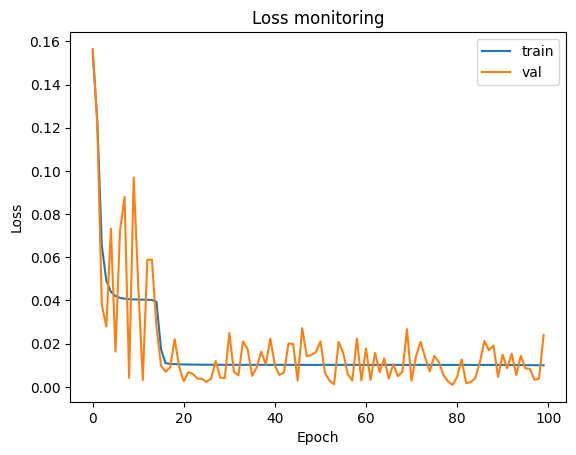

In [34]:
# Instantiating the model and hyperparameters
model = LinearAutoencoder().to(device)
n_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
linear_model_a = train_test_model(model, train_loader_a, val_loader_a, n_epochs, optimizer)

epoch [1/100], Train loss: 0.1653 Valid: 0.1333
epoch [11/100], Train loss: 0.0955 Valid: 0.0819
epoch [21/100], Train loss: 0.0412 Valid: 0.0703
epoch [31/100], Train loss: 0.0271 Valid: 0.0389
epoch [41/100], Train loss: 0.0167 Valid: 0.0150
epoch [51/100], Train loss: 0.0077 Valid: 0.0104
epoch [61/100], Train loss: 0.0059 Valid: 0.0055
epoch [71/100], Train loss: 0.0056 Valid: 0.0045
epoch [81/100], Train loss: 0.0055 Valid: 0.0031
epoch [91/100], Train loss: 0.0053 Valid: 0.0073


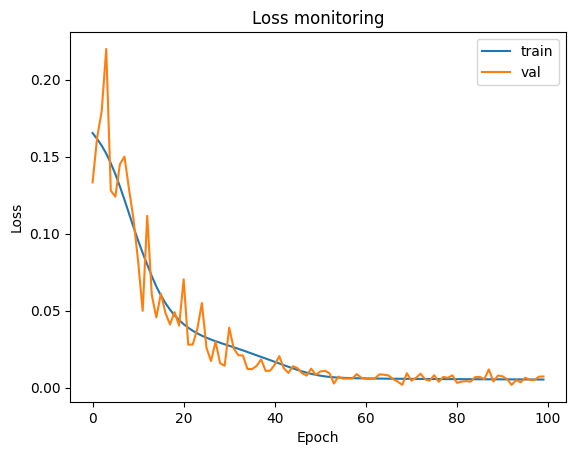

In [35]:
# initialize the NN
model = ConvAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
n_epochs=100
cnn_model_a = train_test_model(model, train_loader_a, val_loader_a, n_epochs, optimizer)

The convolutional autoencoder for amplitude scale spectrograms behaves with the least loss out of the trained models.

# Exploring Output

In this section I will plot 10 examples of the latent space and reconstructed images from each of the trained networks for both the dB scale and amplitude scale spectrograms.

## dB Scale

### Linear Autoencoder Results

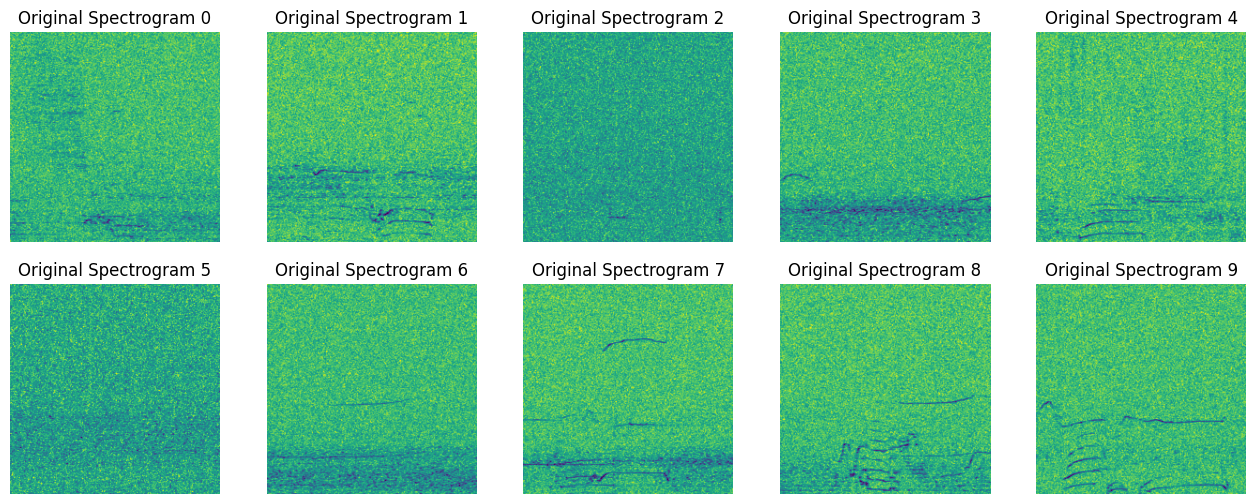

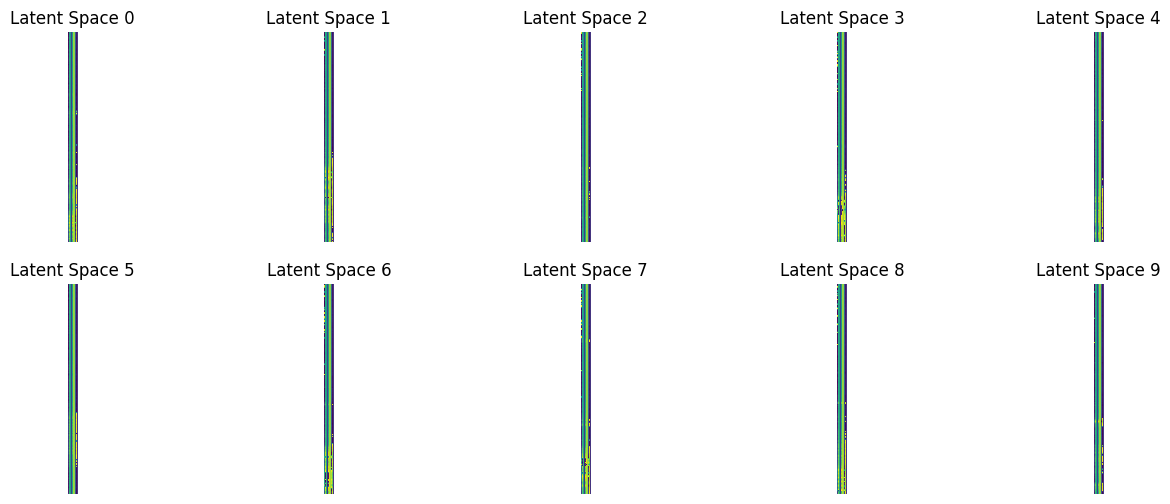

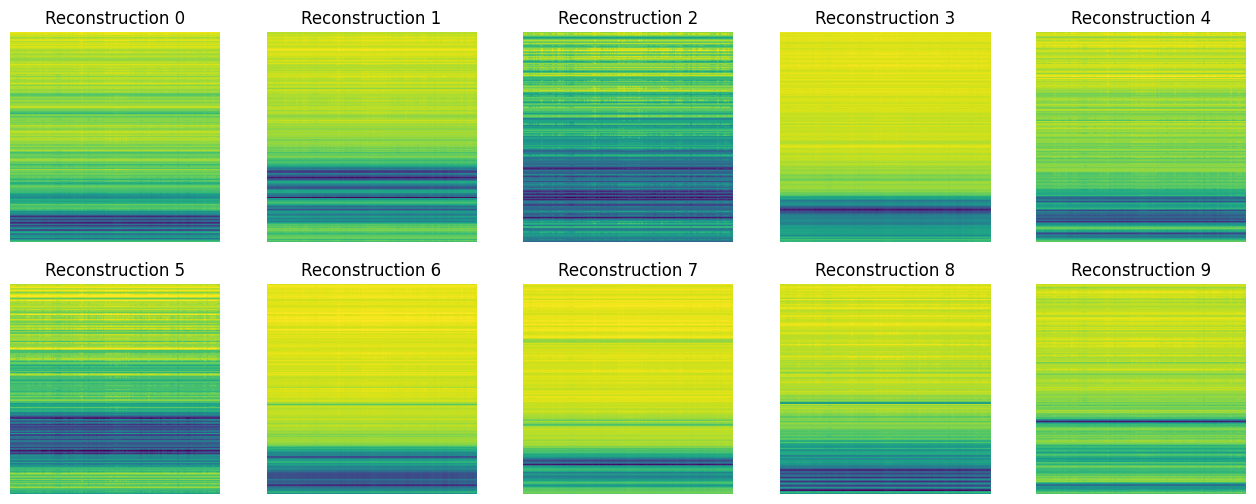

In [36]:
transform = transforms.ToPILImage()
fig1 = plt.figure(figsize=(16, 6))
fig2 = plt.figure(figsize=(16, 6))
fig3 = plt.figure(figsize=(16, 6))
for idex, data in enumerate(entireset_db):
    if idex<10:
        
        img, _ = data
        img = img.to(device)
        
        imgs = img.squeeze()
        imgs = transform(imgs)
        
        lspace = linear_model_db.encoder(img)
        lspaces = lspace.squeeze()
        image_l = transform(lspaces)
        
        output = linear_model_db(img)
        output_sq = output.squeeze()
        image_o = transform(output_sq)
        
        plt.figure(1)
        plt.subplot(2, 5, idex + 1)
        plt.imshow(imgs)
        plt.title('Original Spectrogram ' + str(idex))
        plt.axis('off');
        
        plt.figure(2)
        plt.subplot(2, 5, idex + 1)
        plt.imshow(image_l)
        plt.title('Latent Space ' + str(idex))
        plt.axis('off');
        
        plt.figure(3)
        plt.subplot(2, 5, idex + 1)
        plt.imshow(image_o)
        plt.title('Reconstruction ' + str(idex))
        plt.axis('off');

As seen above, the linear autoencoder does not produce acceptable reconstructions of the input spectrograms. For this reason, the linear autoencoder will not be used going forward in this project.

### Convolutional Autoencoder Results

#### Plots

In [37]:
# Plot the original, latent space, and reconstructed spectrograms for the dB scale dataset
lspacess = []
labels = []
transform = transforms.ToPILImage()
fig1 = plt.figure(figsize=(16, 6))
fig2 = plt.figure(figsize=(16, 6))
fig3 = plt.figure(figsize=(16, 6))
for idex, data in enumerate(entireset_db):
    
    # plotting
    if idex<10:
        
        img, _ = data
        img = img.to(device)

        imgs = img.squeeze()
        imgs = transform(imgs)

        lspace = cnn_model_db.encoder(img)
        lspaces = lspace.squeeze()
        image_l = transform(lspaces)

        output = cnn_model_db(img)
        output_sq = output.squeeze()
        image_o = transform(output_sq)

        plt.figure(1)
        plt.subplot(2, 5, idex + 1)
        plt.imshow(imgs)
        plt.title('Original Spectrogram ' + str(idex))
        plt.axis('off');

        plt.figure(2)
        plt.subplot(2, 5, idex + 1)
        plt.imshow(image_l)
        plt.title('Latent Space ' + str(idex))
        plt.axis('off');

        plt.figure(3)
        plt.subplot(2, 5, idex + 1)
        plt.imshow(image_o)
        plt.title('Reconstruction ' + str(idex))
        plt.axis('off');

Output hidden; open in https://colab.research.google.com to view.

#### UMAP

In [38]:
# For the entire dataset with dB scaling, generate latent space vectors for use with UMAP clustering
lspaces = []
labels = []

# for each spectrogram within the dataset 
for data in entireset_db:
    img, _ = data
    img = img.to(device)

    # generate a latent space from the encoder 
    lspace = cnn_model_db.encoder(img)
    output = cnn_model_db(img)

    # flatten the latent space 
    lspacef = torch.flatten(lspace, start_dim=1, end_dim=-1)

    # send it to the cpu 
    lspacen = lspacef.to('cpu')

    # make it a numpy array 
    lspacen = lspacen.detach().numpy()

    # attach to the list of all latent spaces 
    lspaces.append(lspacen)

    # change the labels from "call" and "no call" to 1 and 0 respectively 
    if data[1][0]=='call':
        labels.append(1)
    else:
        labels.append(0)

In [39]:
# for easier access to latent space arrays 
edited = []
for ii in range(0, len(lspaces)):
    edited.append(lspaces[ii][0])

In [40]:
# create a dataframe containing the latent space vectors 
df_db = pd.DataFrame(edited)

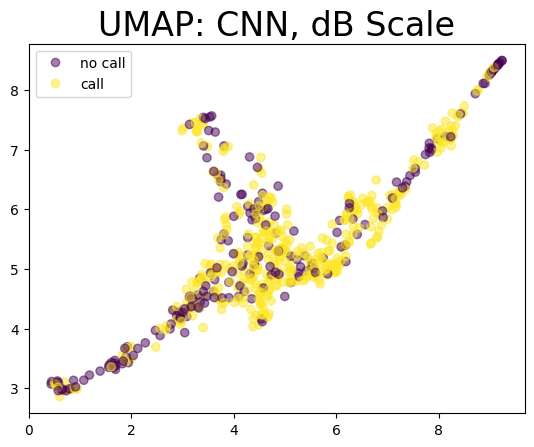

In [130]:
# use UMAP to plot the latent space representations and colour according to their annotation
reducer = umap.UMAP(n_components = 3)
call_names = ['no call', 'call']
embedding = reducer.fit_transform(df_db)
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels, alpha=0.5)
plt.legend(handles = scatter.legend_elements()[0], labels=call_names)
plt.title('UMAP: CNN, dB Scale', fontsize=24);

In [140]:
def draw_umap(data, title, n_neighbors=5, n_components=3):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=n_components,
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=labels)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=labels)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=labels, s=5)
    plt.title(title, fontsize=18)

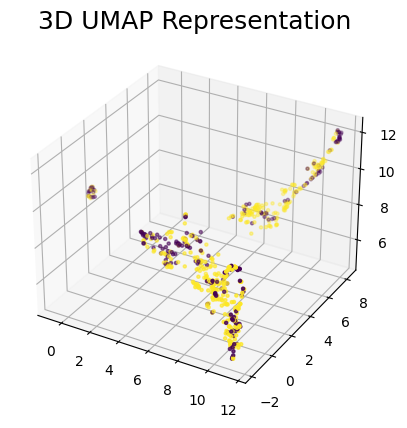

In [142]:
draw_umap(df_db, '3D UMAP Representation')

In [47]:
hover_data = pd.DataFrame({'index':np.arange(594),
                           'label':labels})
hover_data['item'] = hover_data.label.map(
    {
        0:'no call',
        1:'call'
    }
)

In [48]:
#https://umap-learn.readthedocs.io/en/0.4dev/plotting.html
umap.plot.output_notebook()
mapper = umap.UMAP().fit(df_db)

In [49]:
p = umap.plot.interactive(mapper, labels=labels, hover_data=hover_data, point_size=8, theme='blue')
umap.plot.show(p)

Text(0.5, 1.0, 'KMean Cluster Colouring on UMAP Projection')

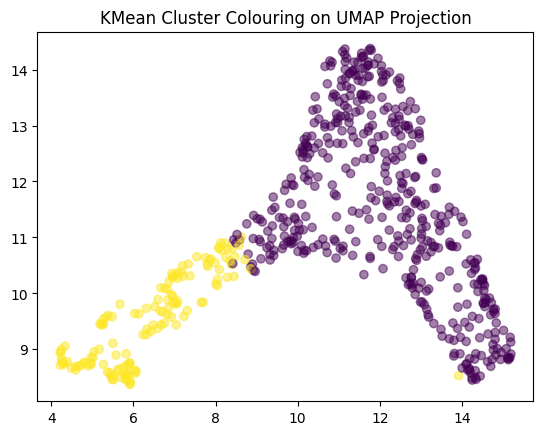

In [50]:
kmeans = KMeans(n_clusters=2, init="random", n_init=10, max_iter=300, random_state=42)
label_kmean = kmeans.fit_predict(df_db)

df['kmeanc'] = label_kmean

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=label_kmean, alpha=0.5)
plt.title('KMean Cluster Colouring on UMAP Projection')


## Amplitude Scale 

#### Plots

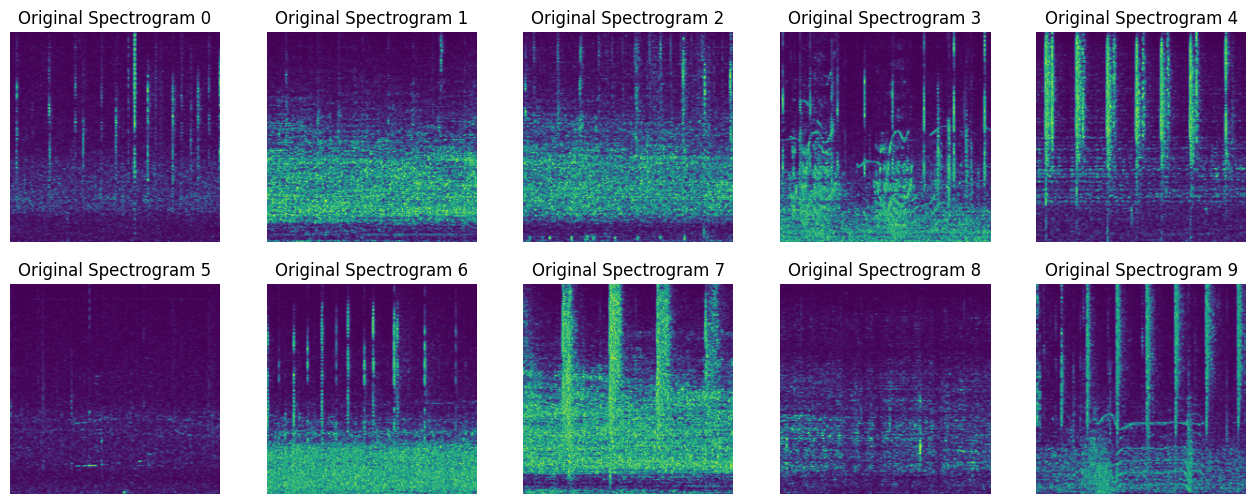

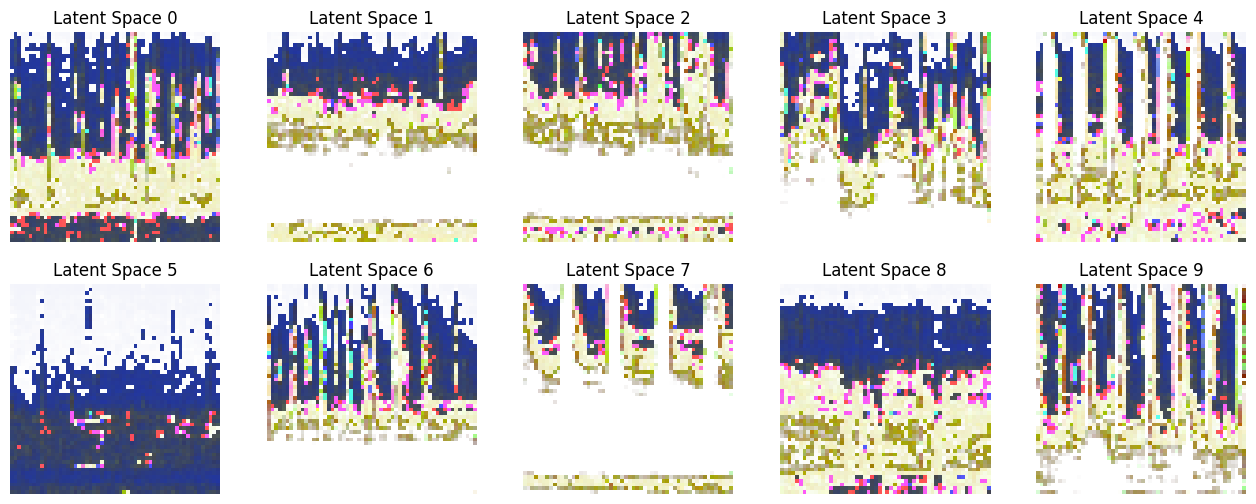

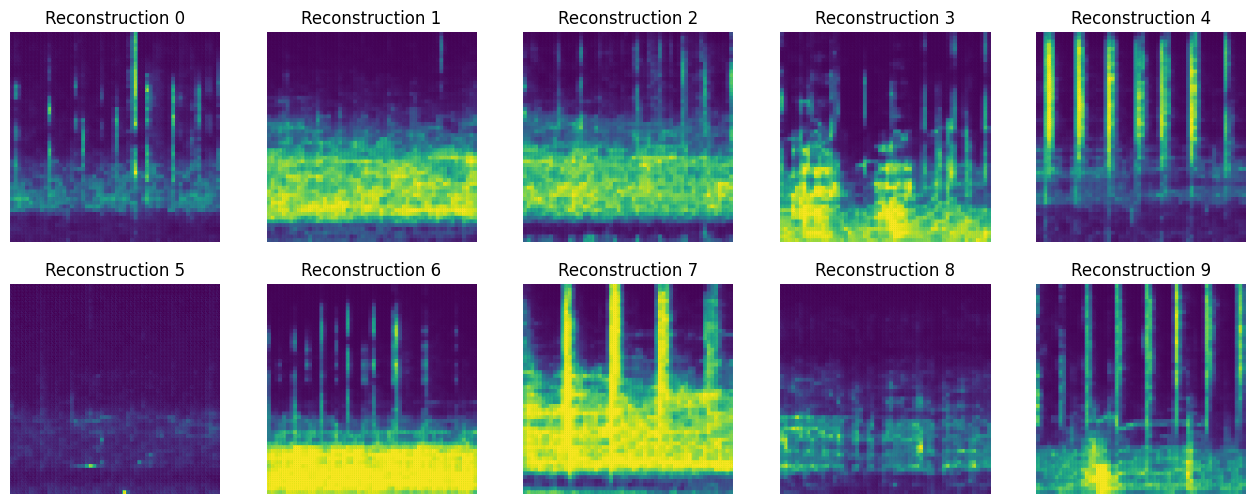

In [52]:
lspacess = []
labels = []
transform = transforms.ToPILImage()
fig1 = plt.figure(figsize=(16, 6))
fig2 = plt.figure(figsize=(16, 6))
fig3 = plt.figure(figsize=(16, 6))
for idex, data in enumerate(entireset_a):
    
    # plotting
    if idex<10:
        
        img, _ = data
        img = img.to(device)

        imgs = img.squeeze()
        imgs = transform(imgs)

        lspace = cnn_model_a.encoder(img)
        lspaces = lspace.squeeze()
        image_l = transform(lspaces)

        output = cnn_model_a(img)
        output_sq = output.squeeze()
        image_o = transform(output_sq)

        plt.figure(1)
        plt.subplot(2, 5, idex + 1)
        plt.imshow(imgs)
        plt.title('Original Spectrogram ' + str(idex))
        plt.axis('off');

        plt.figure(2)
        plt.subplot(2, 5, idex + 1)
        plt.imshow(image_l)
        plt.title('Latent Space ' + str(idex))
        plt.axis('off');

        plt.figure(3)
        plt.subplot(2, 5, idex + 1)
        plt.imshow(image_o)
        plt.title('Reconstruction ' + str(idex))
        plt.axis('off');

#### UMAP

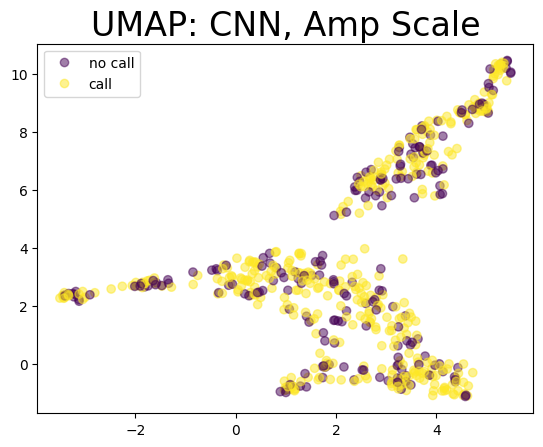

In [143]:
lspaces = []
labels = []
for data in entireset_a:
    img, _ = data
    img = img.to(device)
    lspace = cnn_model_a.encoder(img)
    output = cnn_model_a(img)
    #print(lspace.shape)
    lspacef = torch.flatten(lspace, start_dim=1, end_dim=-1)
    #print(lspacef.shape)
    lspacen = lspacef.to('cpu')
    lspacen = lspacen.detach().numpy()
    lspaces.append(lspacen)
    if data[1][0]=='call':
        labels.append(1)
    else:
        labels.append(0)

edited = []
for ii in range(0, len(lspaces)):
    edited.append(lspaces[ii][0])

df_a = pd.DataFrame(edited)

reducer = umap.UMAP()
sp_names = ['no call', 'call']
embedding = reducer.fit_transform(df)
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels, alpha=0.5)
plt.legend(handles = scatter.legend_elements()[0], labels=sp_names)
plt.title('UMAP: CNN, Amp Scale', fontsize=24);


hover_data = pd.DataFrame({'index':np.arange(594),
                           'label':labels})
hover_data['item'] = hover_data.label.map(
    {
        0:'no call',
        1:'call'
    }
)

#https://umap-learn.readthedocs.io/en/0.4dev/plotting.html
umap.plot.output_notebook()
mapper = umap.UMAP().fit(df)

p = umap.plot.interactive(mapper, labels=labels, hover_data=hover_data, point_size=8, theme='blue')
umap.plot.show(p)

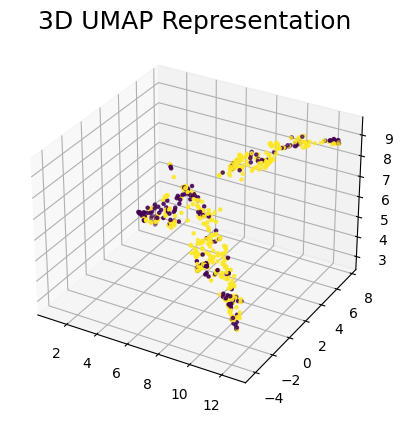

In [144]:
draw_umap(df_a, '3D UMAP Representation')

Text(0.5, 1.0, 'KMean Cluster Colouring on UMAP Projection')

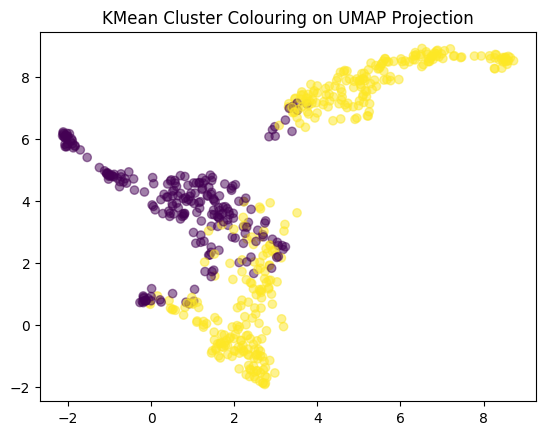

In [55]:
kmeans = KMeans(n_clusters=2, init="random", n_init=10, max_iter=300, random_state=42)
label_kmean = kmeans.fit_predict(df)

df['kmeanc'] = label_kmean

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=label_kmean, alpha=0.5)
plt.title('KMean Cluster Colouring on UMAP Projection')

# Discussion

Two relatively simple autoencoders were trained on a 594 sample dataset containing orca vocalizations. The convolutional autoencoder outperformed the linear autoencoder, and the amplitude scale spectrograms outperformed the dB scale spectrograms in terms of lower training loss. 

For both dB scale and amplitude scale spectrograms, the decoder from the convolutional autoencoder was used to generate a latent space for each file. UMAP was then used to visualize the structure within the data. 

For both the amplitude and dB scale spectrograms, there was no clear separation within the UMAP representation between "call" and "no call" segments.

# Appendix: Classification (not working properly)

Below I attempted to use transfer learning to create a binary classifier using ResNet-50, but the 2d output has the same number in both columns as of now. I ran out of time to figure out the error. 

https://www.kaggle.com/code/pmigdal/transfer-learning-with-resnet-50-in-pytorch

In [100]:
# Train/test loop for resnet: needed to also pass in the labels for the loss criterion 
def train_test_model_resnet(model, train_loader, val_loader, n_epochs, optimizer):
    criterion = nn.MSELoss()
    optimizer = optimizer
    model = model.train()
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        train_batch_losses = []
        val_batch_losses = []
        for data in train_loader:
            img, label = data
            img = img.to(device)
            label = label.to(device)
            #print(label)
            
            output = model(img)
            loss = criterion(output, label.float())
            #************************ backward *************************
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_batch_losses.append(loss.item()) 
            
        model = model.eval()
        for data in val_loader:
            output = model(img)
            loss = criterion(output, label.float())
            val_batch_losses.append(loss.item())
            
        train_loss = np.mean(train_batch_losses)
        val_loss = np.mean(val_batch_losses)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
            
        # ***************************** log ***************************
        if epoch % 10 == 0:
            print(f"epoch [{epoch + 1}/{n_epochs}], Train loss:{train_loss: .4f} Valid:{val_loss: .4f}")
            
    ax = plt.figure().gca()
    ax.plot(train_losses)
    ax.plot(val_losses)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'])
    plt.title('Loss monitoring')
    plt.show()
    
    return model.eval()

In [64]:
# define new preprocess to make image grayscale with 3 channels so data is compatible with resnet
def preprocess_resnet():
    
    transform =  transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3), 
        transforms.ToTensor()])
  
    return transform

In [121]:
# initialize transform 
transforms_r = preprocess_resnet()

# get new annotation file where I changed "call" and "no call" to 1 and 0 respectively 
annotations_file_r = r"/content/drive/MyDrive/Masters/PHYS555/DL/annotations-edited-resnet.csv"

# create a new dataset for resnet
orca_dataset_res = OrcaImageDataset(annotations_file_r, img_dir, transform=transforms_r)
labels_r = orca_dataset_res.img_labels

In [122]:
# split into training, testing, and validation
xtrain_data_r, test_data_r, ytrain_labels_r, test_labels_r = train_test_split(orca_dataset_res, labels_r, test_size=0.2, random_state=21)

#  split a validation set from the training set
train_data_r, val_data_r, train_labels_r, val_labels_r = train_test_split(
    xtrain_data_r, ytrain_labels_r, test_size=0.2, random_state=22)


In [123]:
# create dataloaders 
batch_size = 1
train_loader_r = DataLoader(train_data_r, batch_size=batch_size, shuffle=True)
val_loader_r = DataLoader(val_data_r, batch_size=batch_size, shuffle=True)
test_loader_r = DataLoader(test_data_r, batch_size=batch_size, shuffle=True)

entireset_res = DataLoader(orca_dataset_res, batch_size=batch_size, shuffle=True)

In [124]:
# load in pretrained resnet 50
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   

# set the fully connected layers to predict 2 predictions, and train these layers for my data 
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch [1/100], Train loss: 0.2702 Valid: 0.3293
epoch [11/100], Train loss: 0.0845 Valid: 0.0035
epoch [21/100], Train loss: 0.0506 Valid: 0.0228
epoch [31/100], Train loss: 0.0368 Valid: 0.0008
epoch [41/100], Train loss: 0.0186 Valid: 0.0226
epoch [51/100], Train loss: 0.0096 Valid: 0.0272
epoch [61/100], Train loss: 0.0116 Valid: 0.0000
epoch [71/100], Train loss: 0.0074 Valid: 0.0152
epoch [81/100], Train loss: 0.0067 Valid: 0.0000
epoch [91/100], Train loss: 0.0050 Valid: 0.0000


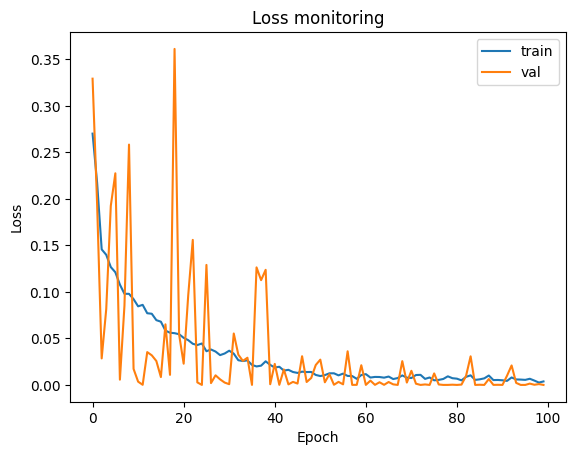

In [125]:
# set the optimizer and train the model 
optimizer = optim.Adam(model.fc.parameters())
model_trained = train_test_model_resnet(model, train_loader_r, val_loader_r, n_epochs, optimizer)

In [126]:
preds = []
for idex, data in enumerate(entireset_res):

        img, label = data
        img = img.to(device)

        output = model_trained(img)
        #print(output.shape)
        #print(output[0])
        pred = output.cpu().detach().numpy()
        #print(pred)

        preds.append(pred)

In [146]:
print(preds[0][0])

# These shouldn't be the same number... but I ran out of time

[-0.00184261 -0.0018426 ]


# References 

Orca dataset: https://github.com/earthspecies/library/tree/main/orcas

ResNet-50 transfer learning: https://www.kaggle.com/code/pmigdal/transfer-learning-with-resnet-50-in-pytorch

Dataloaders: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

UMAP: https://umap-learn.readthedocs.io/en/latest/

dB-Scale Motivation from: Bergler et. al. ORCA-SPOT: An automatic killer whale sound detection toolkit using deep learning. 2019. doi: 10.1038/s41598-019-47335-w

PyTorch documentation: https://pytorch.org/docs/stable/index.html